In [11]:
import nltk
import pandas as pd 

from nltk.corpus import stopwords
from gensim import corpora

In [12]:
df = pd.read_csv("../reports/figures/sentiment_comparison.csv", index_col=0)
df = df.sort_values('sent_distance', ascending=False)

In [13]:
df.columns

Index(['País', 'Título', 'Calificación', 'Descripción', 'Fecha del chequeo',
       'Organización', 'Link al chequeo', 'Tipo de información',
       'Formato de la desinformación', 'Tipo de nota',
       'Link a la desinformación', 'Fecha detección desinformación', 'Origen',
       'Persona', 'Actualizaciones', 'Circuló en otros países', 'Unnamed: 16',
       'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'en_title_sent',
       'en_desc_sent', 'en_lemma_title_sent', 'en_lemma_desc_sent',
       'Título_full_translation', 'Descripción_full_translation',
       'body_lem_title_sent', 'body_stem_title_sent', 'body_lem_desc_sent',
       'body_stem_desc_sent', 'sent_distance'],
      dtype='object')

In [52]:
df.loc[df['Título_full_translation'].str.contains('quot'), 'Título_full_translation'].iloc[0]

'An image that ensures that healthy people have to wear the white part of surgical masks to the outside to &quot;protect themselves&quot; from the virus'

In [79]:
'the' in en_stopwords

True

In [81]:
import re
en_stopwords = set(stopwords.words('english') + ['&quot', 'quot'])
punctuations = '''!()-[]{}';:'"\,<>./?@#$%^&*_~``'''
def replace_quot(string):
    return string.replace('&quot;', '"')

def norm_word(word):
    return re.sub('[^a-zA-Z]+', ' ', replace_quot(word)).lower()


df['title_bigrams'] = (
    df['Título_full_translation']
    .apply(
        lambda row: list(
            nltk.ngrams(
                [
                    norm_word(word) for word in nltk.word_tokenize(row) 
                    if (norm_word(word) not in en_stopwords) and (norm_word(word) not in punctuations)
                ],
                2,
            )
        )
    )
)


In [82]:
bigrams = [[[bigram[0], bigram[1]] for bigram in x] for x in df['title_bigrams']]
bigrams = sum(bigrams, [])
dictionary = corpora.Dictionary(bigrams)
corpus = [dictionary.doc2bow(text) for text in bigrams]

In [83]:
from gensim import models
NUM_TOPICS = 6
ldamodel = models.ldamodel.LdaModel(
    corpus, 
    num_topics=NUM_TOPICS, 
    id2word=dictionary, 
    passes=25,
    random_state=99)

In [84]:
topics = ldamodel.print_topics(num_words=15)
for topic in topics:
    print(topic)

(0, '0.063*"vaccine" + 0.022*"spain" + 0.021*"cures" + 0.016*"deaths" + 0.016*"mask" + 0.014*"causes" + 0.013*"covid" + 0.012*"gates" + 0.011*"argentine" + 0.010*"home" + 0.008*"one" + 0.008*"bill" + 0.007*"children" + 0.007*"different" + 0.007*"possible"')
(1, '0.190*"coronavirus" + 0.035*"new" + 0.023*"use" + 0.021*"doctor" + 0.021*"said" + 0.016*"claims" + 0.011*"video" + 0.011*"showing" + 0.011*"spread" + 0.010*"doctors" + 0.010*"shows" + 0.010*"false" + 0.009*"without" + 0.009*"spanish" + 0.008*"prevents"')
(2, '0.028*"cure" + 0.026*"people" + 0.026*"video" + 0.014*"infected" + 0.013*"fern ndez" + 0.012*"says" + 0.012*"social" + 0.011*"virus" + 0.011*"venezuela" + 0.010*"alleged" + 0.009*"ensures" + 0.009*"disease" + 0.009*"mexico" + 0.009*"states" + 0.008*"death"')
(3, '0.026*"pandemic" + 0.023*"masks" + 0.020*"due" + 0.015*"hospital" + 0.014*" g" + 0.013*"country" + 0.012*"china" + 0.011*"prevent" + 0.010*"minister" + 0.008*"would" + 0.008*"us" + 0.008*"de" + 0.008*"buenos" + 0.

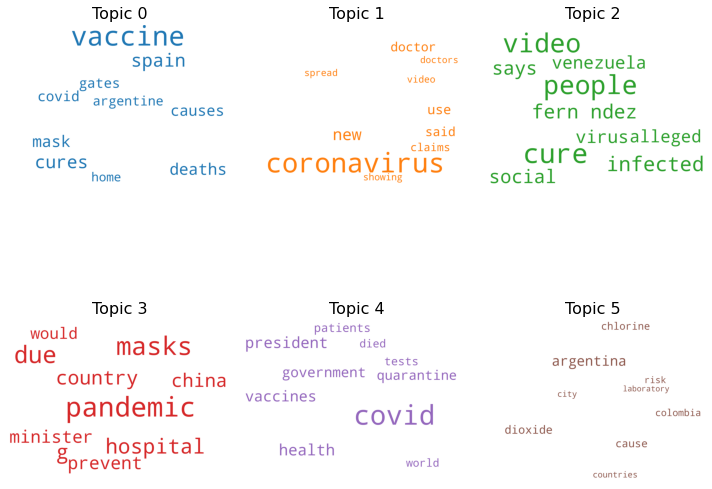

In [85]:
# https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=en_stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = ldamodel.show_topics(formatted=False)

fig, axes = plt.subplots(2, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()